https://www.kaggle.com/code/ekhtiar/resunet-a-baseline-on-tensorflow/notebook

In [1]:
import os

import keras.metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.model_selection import train_test_split
import utilities
from utilities import DataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.chdir('data/Healthcare AI Datasets/Brain_MRI')
brain_df = pd.read_csv('data_mask.csv')

In [3]:
IMG_SIZE = 128

In [4]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

#TODO: entrenando con todo
X_train, X_val = train_test_split(brain_df, test_size=0.15, random_state=2020)
X_test, X_val = train_test_split(X_val, test_size=0.5, random_state=2020)

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

training_generator = DataGenerator(train_ids,train_mask, img_h = IMG_SIZE, img_w = IMG_SIZE)
validation_generator = DataGenerator(val_ids,val_mask,  img_h = IMG_SIZE, img_w = IMG_SIZE)

X, y = validation_generator.__getitem__(2)

plt.imshow(X[0])

plt.imshow(y[0])

from skimage import io
img_path = 'TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif'
mask_path = 'TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif'

z = np.empty((2, IMG_SIZE, IMG_SIZE, 3),)
for i in range(2):
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    img = cv2.resize(img,(128 ,128), interpolation = cv2.INTER_NEAREST)
    mask = cv2.resize(mask,(128 ,128), interpolation = cv2.INTER_NEAREST)

    mask = np.maximum(img, mask)

    z[i] = mask/255

plt.imshow(z[0])

In [5]:
def batchnorm_relu(inputs):
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)

    return x

def residual_block(inputs, num_filters, strides=1):
    # Convolutional Layers
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    # Shortcut Connection (Identity Mapping)
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    x = x + s
    return x


def decoder_block(inputs, skip_features, num_filters):
    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x


def build_resunet(input_shape):
    inputs = Input(input_shape)

    # Endoder 1
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs) # Skip connection
    s1 = x + s

    # Encoder 1 & 2
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    # Bridge
    b = residual_block(s3, 512, strides=2)

    # Decoders
    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    # Classifier
    #outputs = Conv2D(1, 1, padding="same", activation="sigmoid")
    outputs = Conv2D(3, (1,1), padding = "same", activation = "sigmoid")(x) #TODO: no se que es esto

    #Model
    model = Model(inputs, outputs, name="RESUNET")

    return model

shape = (IMG_SIZE, IMG_SIZE, 3)
model = build_resunet(shape)
model.summary()

Model: "RESUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [6]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)

model.compile(optimizer='adam',
            loss=utilities.focal_tversky, metrics=[utilities.tversky])

In [7]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=1, monitor='val_tversky')

In [8]:
history = model.fit(training_generator,
                    epochs = 2,
                    validation_data=validation_generator,
                    batch_size=16,
                    validation_batch_size=16,
                    callbacks=[early_stopping_cb])

Epoch 1/2
208/208 [==============================] - 2562s 12s/step - loss: 0.5840 - tversky: 0.5114 - val_loss: 0.6899 - val_tversky: 0.3903
Epoch 2/2
208/208 [==============================] - 2503s 12s/step - loss: 0.5588 - tversky: 0.5396 - val_loss: 0.5810 - val_tversky: 0.5149


In [9]:
#model.predict()

img = validation_generator.__getitem__(2)
res = model.predict(img[0])

1/1 [==============================] - 3s 3s/step


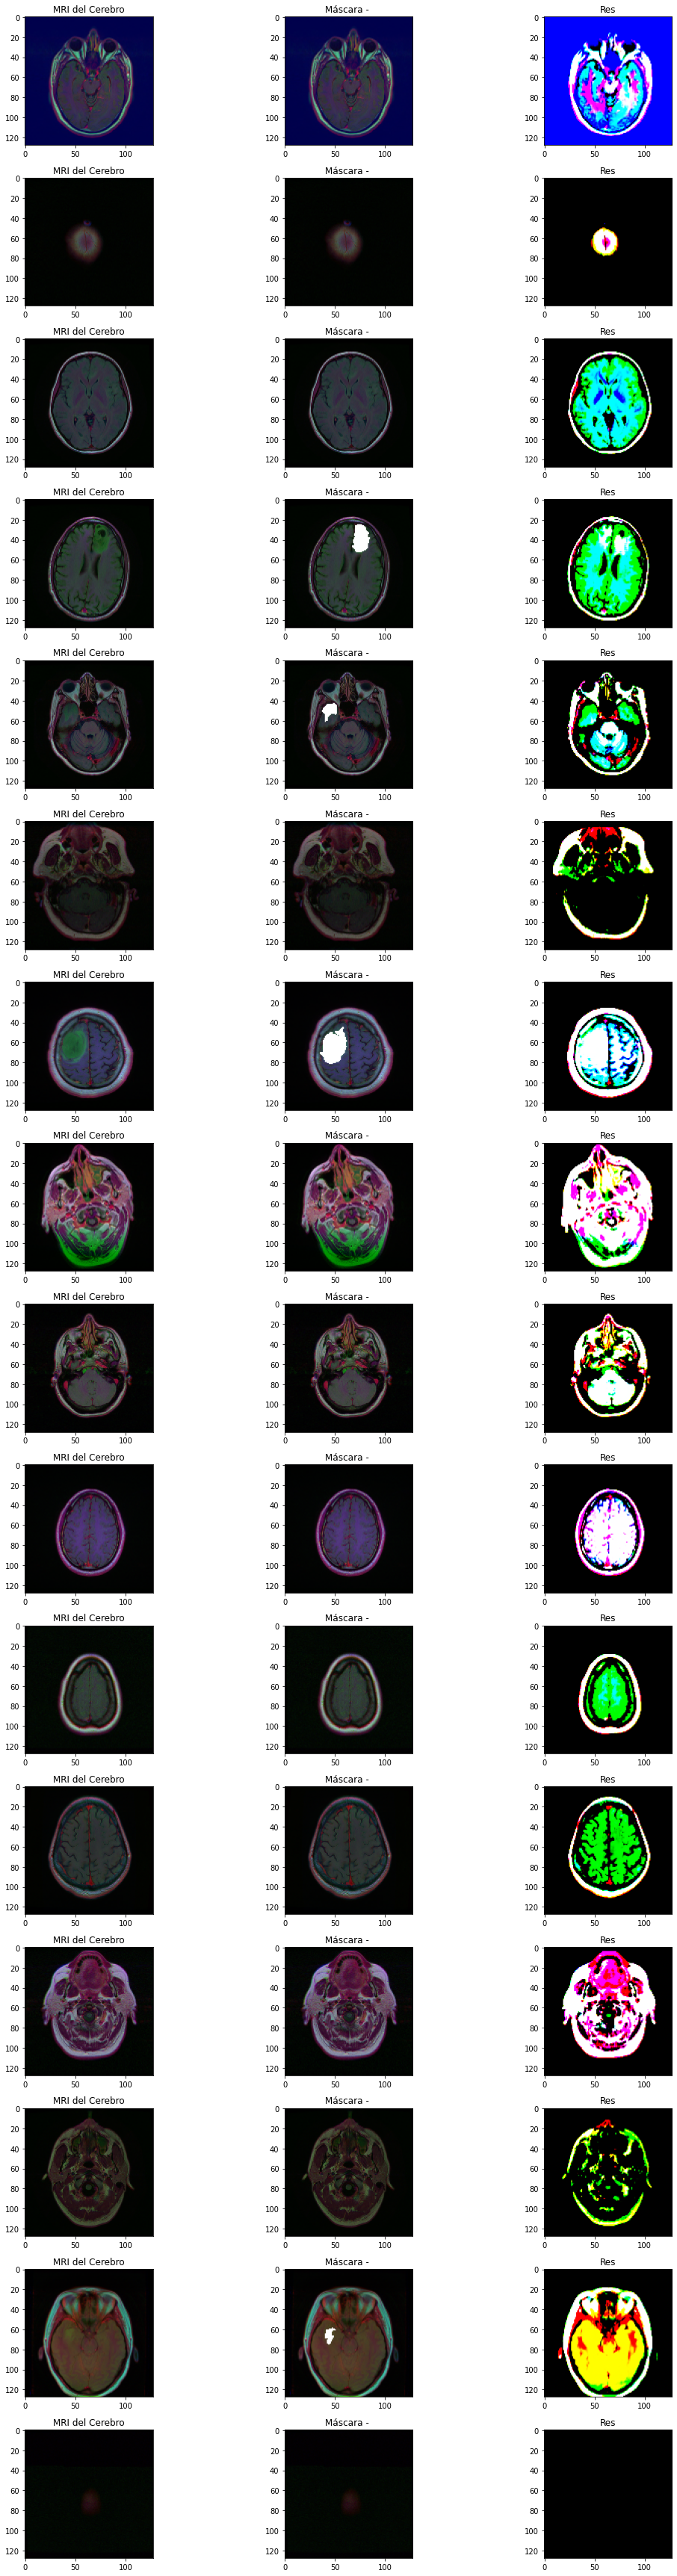

In [10]:
fig, axs = plt.subplots(16,3, figsize=(16,16*3))

for x in range(16):
  axs[x][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[x][0].imshow(img[0][x]) # Mostramos la MRI
  axs[x][1].title.set_text("Máscara - " ) # Colocámos el título en la máscara (0 o 1)
  axs[x][1].imshow(img[1][x]) # Mostramos la máscara correspondiente
  axs[x][2].imshow(res[x])
  axs[x][2].title.set_text("Res")

fig.tight_layout()

In [12]:
img = training_generator.__getitem__(2)
res = model.predict(img[0])

1/1 [==============================] - 3s 3s/step


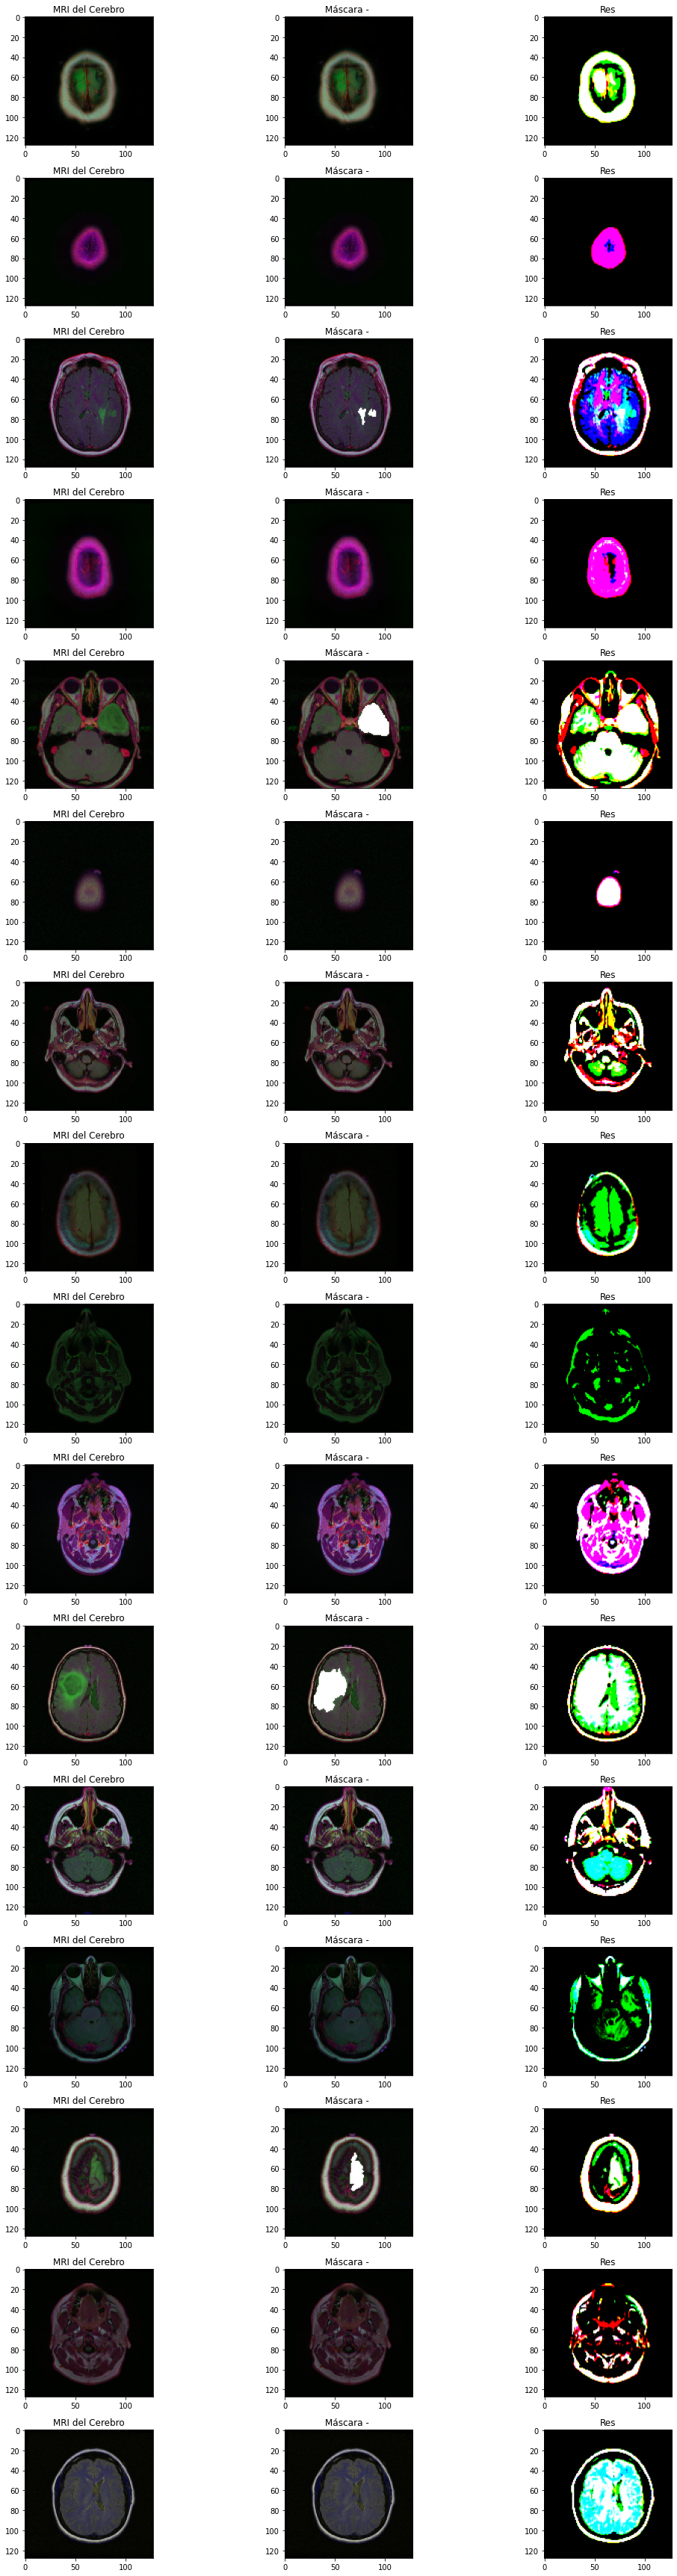

In [13]:
fig, axs = plt.subplots(16,3, figsize=(16,16*3))

for x in range(16):
  axs[x][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[x][0].imshow(img[0][x]) # Mostramos la MRI
  axs[x][1].title.set_text("Máscara - " ) # Colocámos el título en la máscara (0 o 1)
  axs[x][1].imshow(img[1][x]) # Mostramos la máscara correspondiente
  axs[x][2].imshow(res[x])
  axs[x][2].title.set_text("Res")

fig.tight_layout()

In [ ]:

with open("ResUNet_tumors_pre_alpha.json","w") as json_file:
    json_file.write(model.to_json())